# PPE analysis template
- Daniel Kennedy (djk2120@ucar.edu)
- updated January 23, 2022
- note that there are dependencies to other files in the repo

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm
import os

In [2]:
### import some analysis functions we wrote for this project
###  note that you can inspect the code for these functions in ../ppe_tools/analysis.py
import sys ; sys.path.append("..")
from ppe_tools.analysis import *

### optional: set up your PBSCluster
- not necessary if you are working with preprocessed data
- client.cluster will show when your workers are active
- note it can take a few minutes to get through the job queue
- set up to ask for 1hr, but can be increased

In [8]:
# Setup your PBSCluster

project = 'P93300641' #input your project code

cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='25GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project=project, # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

In [9]:
## wait until workers >0
client.cluster

### Define some info about the ensemble

In [7]:
##client.close()

In [3]:

ds0,la,attrs,paramkey,keys = ppe_init()

In [16]:
ens_name = 'CTL2010'
datavar = 'TLAI'
xmean,iav = calc_mean(ens_name,datavar,domain='pft')

IndexError: list index out of range

In [13]:
x=xmean.isel(pft=np.arange(17)>0)
da = (x/x[:,0]).sum(dim='pft').compute()

KeyError: 'units'

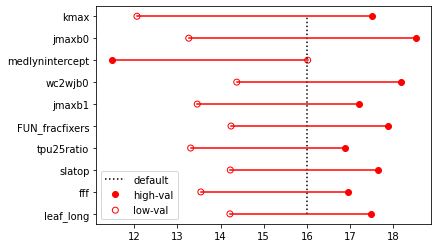

In [15]:
rank_plot(da,ds0,10)

### plot global GPP

In [57]:
xmean,xiav = calc_mean('CTL2010','GPP',la,attrs,ds0)
c285,xiav = calc_mean('C285','GPP',la,attrs,ds0)
c867,xiav = calc_mean('C867','GPP',la,attrs,ds0)


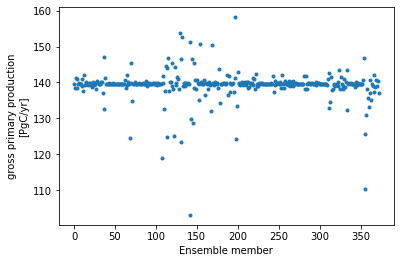

In [44]:
xmean.plot.line('.')
plt.xlabel('Ensemble member')
plt.savefig('/glade/u/home/djk2120/clm5ppe/figs/lmwg22/gpp.png');

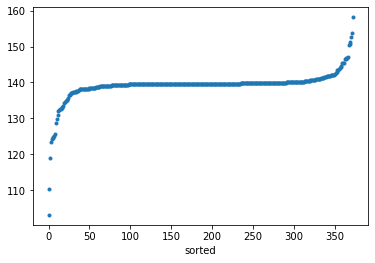

In [45]:
plt.plot(sorted(xmean),'.')
plt.xlabel('sorted')
plt.savefig('/glade/u/home/djk2120/clm5ppe/figs/lmwg22/gpp_sorted.png');

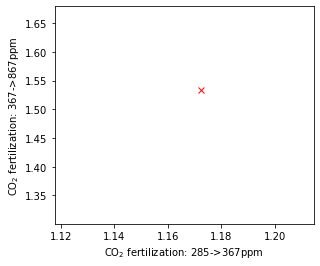

In [109]:
plt.figure(figsize=[6,4])
plt.plot(xmean/c285,c867/xmean,'.',color=[1,1,1])
plt.plot((xmean/c285).sel(ens=0),(c867/xmean).sel(ens=0),'rx')
plt.xlabel(r'CO$_2$ fertilization: 285->367ppm')
plt.ylabel(r'CO$_2$ fertilization: 367->867ppm')
plt.subplots_adjust(left=0.3)
plt.savefig('/glade/u/home/djk2120/clm5ppe/figs/lmwg22/co2fert_def.png');


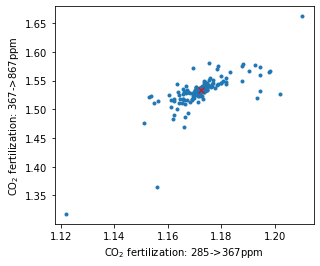

In [110]:
plt.figure(figsize=[6,4])
plt.plot(xmean/c285,c867/xmean,'.')
plt.plot((xmean/c285).sel(ens=0),(c867/xmean).sel(ens=0),'rx')
plt.xlabel(r'CO$_2$ fertilization: 285->367ppm')
plt.ylabel(r'CO$_2$ fertilization: 367->867ppm')
plt.subplots_adjust(left=0.3)
plt.savefig('/glade/u/home/djk2120/clm5ppe/figs/lmwg22/co2fert.png');


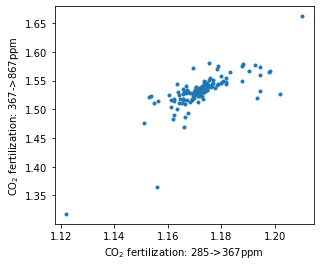

In [104]:
plt.figure(figsize=[6,4])
plt.plot(xmean/c285,c867/xmean,'.')
plt.xlabel(r'CO$_2$ fertilization: 285->367ppm')
plt.ylabel(r'CO$_2$ fertilization: 367->867ppm')
plt.subplots_adjust(left=0.3)
plt.savefig('/glade/u/home/djk2120/clm5ppe/figs/lmwg22/co2fert.png');


In [112]:
x1=1.13
x2=0
ix = ((xmean/c285)<x1)&((c867/xmean)>x2)
print(ds0.param[ix].values,ds0.minmax[ix].values)

['medlynintercept'] ['max']


In [113]:
x1=1.205
x2=100
ix = ((xmean/c285)>x1)&((c867/xmean)<x2)
print(ds0.param[ix].values,ds0.minmax[ix].values)

['kmax'] ['min']


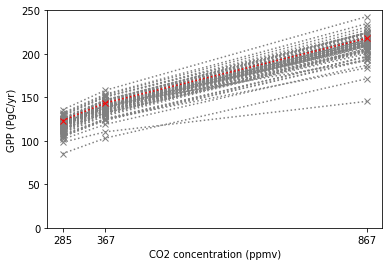

In [95]:
x=np.zeros([3,373])
x[0,:]=c285
x[1,:]=xmean
x[2,:]=c867

plt.plot([285,367,867],x,':x',color=[0.5,0.5,0.5]);
plt.plot([285,367,867],x[:,333],':rx')
plt.xticks([285,367,867])
plt.xlabel('CO2 concentration (ppmv)');
plt.ylabel('GPP (PgC/yr)')
plt.ylim([0,250]);
#plt.xticks([0,1,2],['C285','C367','C867']);

### look at response patterns

In [10]:
files = get_files('CTL2010','h0',keys)
ds = get_ensemble(files,['GPP'],keys,paramkey)

In [27]:
ds.ens[(ds.param=='jmaxb0')&(ds.minmax=='max')]

<xarray.DataArray 'ens' (ens: 1)>
array([129])
Coordinates:
  * ens      (ens) int64 129

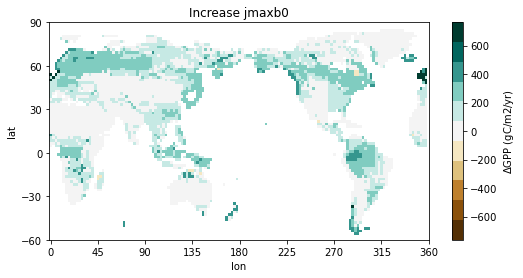

In [34]:
x = 24*60*60*(month_wts(10)*(ds.GPP.isel(ens=129)-ds.GPP.isel(ens=0))).sum(dim='time').compute()/10
clabel = r'$\Delta$GPP (gC/m2/yr)'
plt.figure(figsize=[8.5,4])
get_map(x).plot(cmap=brown_green(),cbar_kwargs={'label':clabel})
plt.title('Increase jmaxb0')
plt.ylim([-60,90])
plt.yticks(-60+30*np.arange(6))
plt.xticks(45*np.arange(9))
plt.savefig('/glade/u/home/djk2120/clm5ppe/figs/lmwg22/nonpft.png');

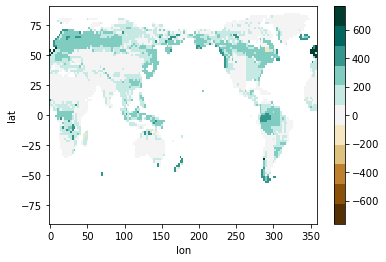

### TV

In [31]:
field = 'NBP'
xmean,xiav = calc_mean('CTL2010',field,la,attrs,ds0)
x1,xiav = calc_mean('NDEP',field,la,attrs,ds0)

NameError: name 'keys' is not defined

In [19]:
ix = (x2-xmean)>4.7
ds0.param[ix]


<xarray.DataArray 'param' (ens: 1)>
array(['tpuse_sf'], dtype='<U32')
Coordinates:
  * ens      (ens) int64 330

In [54]:
pftkeys=['BG','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT',
         'BES','BDMS','BDBS','C3AG','C3NG','C4G','C3C','C3I']

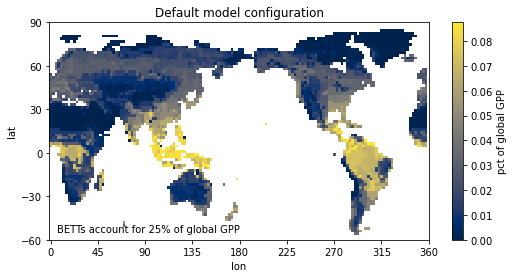

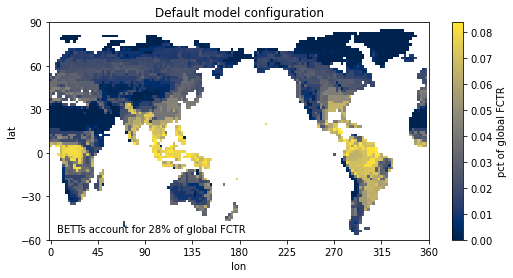

In [69]:
for dv in ['GPP','FCTR']:
    x=(month_wts(10)*ds[dv].isel(ens=0)).sum(dim='time').compute()
    da = get_map(x)
    da = 100*da/da.sum()
    plt.figure(figsize=[8.5,4])
    da.plot(cmap='cividis',cbar_kwargs={'label':'pct of global '+dv})
    plt.ylim([-60,90])
    plt.yticks(-60+30*np.arange(6))
    plt.xticks(45*np.arange(9))
    plt.title('Default model configuration')


    xpft,iav = calc_mean(ens_name, dv, la, attrs, ds0, domain='pft')
    x = xpft.isel(ens=0)
    x = 100*x/x.sum()
    ix = np.argmax(x.values)
    xmax = str(int(np.round(x.max())))
    plt.text(6,-55,pftkeys[ix]+'s account for '+xmax+'% of global '+dv);
    
    plt.savefig('/glade/u/home/djk2120/clm5ppe/figs/lmwg22/'+dv+'map.png')
    

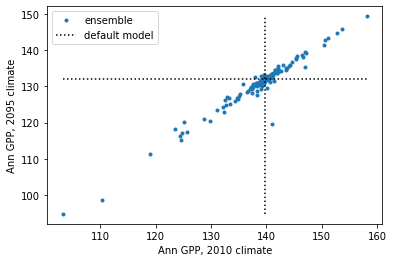

In [82]:
x1,iav = calc_mean('CTL2010', 'GPP', la, attrs, ds0)
x2,iav = calc_mean('AF2095', 'GPP', la, attrs, ds0)

r1=[x1.min(),x1.max()]
r2=[x2.min(),x2.max()]
d1=x1.isel(ens=0)
d2=x2.isel(ens=0)

plt.plot(x1,x2,'.')
plt.plot([d1,d1],r2,'k:')
plt.plot(r1,[d2,d2],'k:')
plt.legend(['ensemble','default model'])
plt.xlabel('Ann GPP, 2010 climate')
plt.ylabel('Ann GPP, 2095 climate');

plt.savefig('/glade/u/home/djk2120/clm5ppe/figs/lmwg22/tpuse_sf.png')

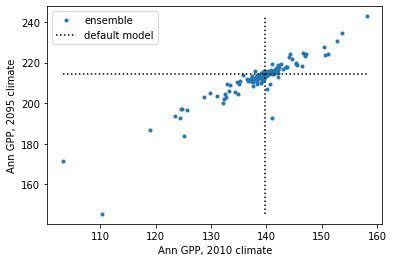

In [87]:
x1,iav = calc_mean('CTL2010', 'GPP', la, attrs, ds0)
x2,iav = calc_mean('C867', 'GPP', la, attrs, ds0)

r1=[x1.min(),x1.max()]
r2=[x2.min(),x2.max()]
d1=x1.isel(ens=0)
d2=x2.isel(ens=0)

plt.plot(x1,x2,'.')
plt.plot([d1,d1],r2,'k:')
plt.plot(r1,[d2,d2],'k:')
plt.legend(['ensemble','default model'])
plt.xlabel('Ann GPP, 2010 climate')
plt.ylabel('Ann GPP, 2095 climate');

#plt.savefig('/glade/u/home/djk2120/clm5ppe/figs/lmwg22/tpuse_sf.png')

In [92]:
ds.param[(x1>140)&(x2<208)]

<xarray.DataArray 'param' (ens: 2)>
array(['jmaxhd', 'tpuse_sf'], dtype='<U32')
Coordinates:
  * ens      (ens) int64 322 330

## Example analyses:
### Working with annual means, at the global/biome/pft levels
- we have a helper function for this purpose (calc_mean)
- it also saves & writes intermediate data so you don't have to recalculate every session

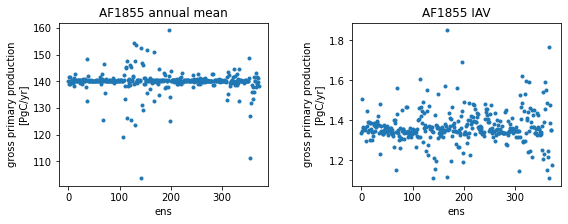

In [34]:
#global means, scatter plot
ens_name = 'AF1855'
datavar  = 'GPP'
domain   = 'global'
xmean,xiav = calc_mean(ens_name,datavar,la,attrs,ds0,domain=domain)

plt.figure(figsize=[9,3])
plt.subplot(121)
xmean.plot.line('.')
plt.title(ens_name+' annual mean')
plt.subplot(122)
xiav.plot.line('.')
plt.title(ens_name+' IAV')
plt.subplots_adjust(wspace=0.4)

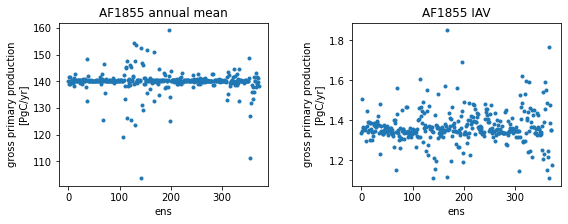

In [35]:
## how to save a figure
filename = '../figs/example.png'
plt.figure(figsize=[9,3])
plt.subplot(121)
xmean.plot.line('.')
plt.title(ens_name+' annual mean')
plt.subplot(122)
xiav.plot.line('.')
plt.title(ens_name+' IAV')
plt.subplots_adjust(wspace=0.4)
plt.savefig(filename)

#note you can examine the printed figure by navigating 
# to it in the left panel


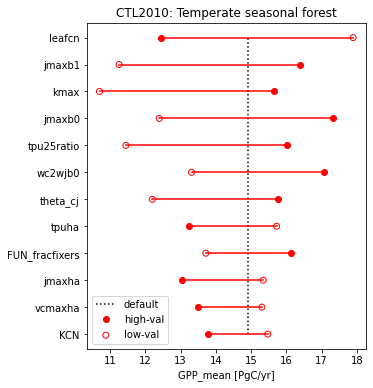

In [9]:
#biome mean, rank_plot

#calc biome-level annual means
ens_name = 'CTL2010'
datavar  = 'GPP'
domain   = 'biome'
xmean,xiav = calc_mean(ens_name,datavar,la,attrs,ds0,domain=domain)

#select the temperate seasonal forest biome
biome=5
bname=str(ds0.biome_name.sel(biome_id=biome).values)
da = xmean.sel(biome=biome)

#rank_plot will rank the parameters by their effects on the given datavar
plt.figure(figsize=[5,6])
rank_plot(da,ds0,12)
plt.title(ens_name+': '+bname);

In [16]:
##access the top_n without plotting
da = xmean.sel(biome=biome)
nx = 10
xmins,xmaxs,pvals=top_n(da,nx,ds0.param,ds0.minmax)
pvals[-1::-1]  #list is in reverse order

['leafcn',
 'jmaxb1',
 'kmax',
 'jmaxb0',
 'tpu25ratio',
 'wc2wjb0',
 'theta_cj',
 'tpuha',
 'FUN_fracfixers',
 'jmaxha']

### Work more directly with the output data
 - you'll probably want to activate the PBSCluster code from the beginning of the notebook 


In [18]:
#load the ensemble
#   monthly='h0', pft='h1', daily='h5'
keys  = paramkey.key
htape = 'h0'
name  = 'CTL2010'
files = get_files(name,htape,keys)
data_vars = ['GPP']
ds = get_ensemble(files,data_vars,keys,paramkey)

### examine GPP, one ensemble member

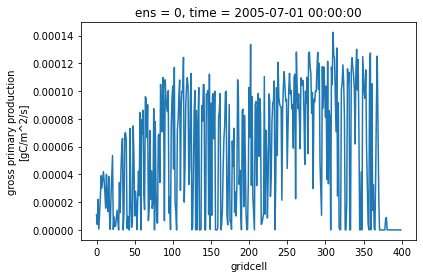

In [19]:
## note that the output is not global, but rather a subset of 400 meaningful pixels
##   so you can't plot a map directly
ds.GPP.isel(ens=0,time=6).plot();    #ens0 = default

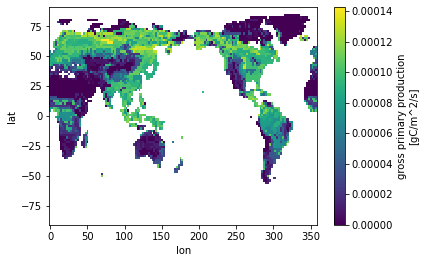

In [20]:
## but we have a function to map the sparsegrid to a global map: get_map
##   it is a little bit slow.....
da_map = get_map(ds.GPP.isel(ens=0,time=6))
da_map.plot();

In [21]:
help(get_map)

Help on function get_map in module ppe_tools.analysis:

get_map(da)
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...



### examine average GPP, all ensemble members

In [22]:
## the perturbations are described via ds.param, ds.minmax
for i in range(10):
    print(ds.param.sel(ens=i).values,ds.minmax.sel(ens=i).values )

default default
taulnir min
taulnir max
taulvis min
taulvis max
tausnir min
tausnir max
tausvis min
tausvis max
rholnir min


### look at a single gridcell

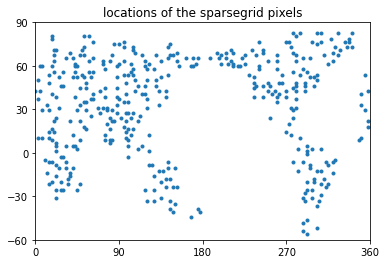

In [23]:
plt.plot(ds.grid1d_lon,ds.grid1d_lat,'.')
plt.xlim([0,360]); plt.xticks(90*np.arange(5))
plt.ylim([-60,90]); plt.yticks(-60+30*np.arange(6))
plt.title('locations of the sparsegrid pixels');

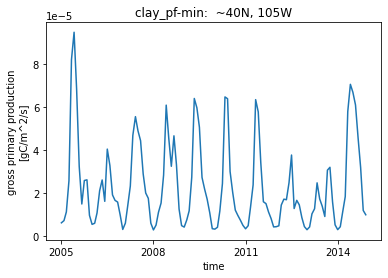

In [26]:
latn = 40
lonw = 105

lat = latn
lon = 360-lonw  #105W

#find nearest point
d = np.sqrt((ds.grid1d_lat-lat)**2+(ds.grid1d_lon-lon)**2)
ix = d==np.min(d)


   
#pick an ensemble member and plot
ee = 368
p = str(ds.param.isel(ens=ee).values)
m = str(ds.minmax.isel(ens=ee).values)

ds.GPP.isel(ens=ee,gridcell=ix).plot()
plt.title(p+'-'+m+':  ~'+str(latn)+'N, '+str(lonw)+'W');
    

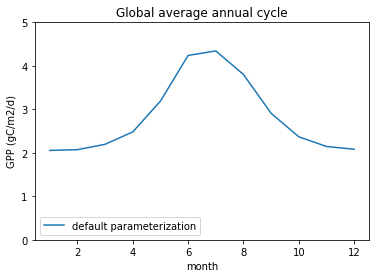

In [27]:
#compute the global annual cycle
cf1 = 24*60*60    #gc/m2/s -> /d
cf2 = 1/la.sum()
units = 'gC/m2/d'

datavar='GPP'
x = cf1*cf2*(la*ds[datavar]).sum(dim='gridcell').groupby('time.month').mean()

x.sel(ens=0).plot()
plt.ylim([0,5])
plt.ylabel(datavar+' ('+units+')')
plt.legend(['default parameterization'],loc=3)
plt.title('Global average annual cycle');

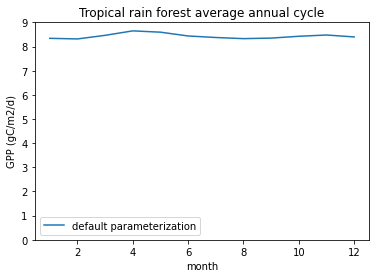

In [28]:
#compute the average annual cycle for a given biome
biome=1  #tropical rain forest
bname=str(ds0.biome_name.sel(biome_id=biome).values)
la_biome = la*(ds0.biome==biome)
cf1 = 24*60*60    #gc/m2/s -> /d
cf2 = 1/la_biome.sum()
units = 'gC/m2/d'

datavar='GPP'
x = cf1*cf2*(la_biome*ds[datavar]).sum(dim='gridcell').groupby('time.month').mean()

x.sel(ens=0).plot()
plt.ylim([0,9])
plt.ylabel(datavar+' ('+units+')');
plt.legend(['default parameterization'],loc=3)
plt.title(bname+' average annual cycle');

### Examine param perturbation values

In [29]:
## if you want to examine the actual values of a given param
param = 'jmaxb1'

## shouldn't need to edit below

ix = ds.param==param
params = ['default',*ds.param.isel(ens=ix).values]
minmax = ['default',*ds.minmax.isel(ens=ix).values]

ix = ds.ens>np.inf
for p,m in zip(params,minmax):
    ix = (ix)|((ds.param==p)&(ds.minmax==m))

keys = ds.key.isel(ens=ix).values
pvals = []
pdir = '/glade/scratch/djk2120/PPEn11/paramfiles/'
ndir = '/glade/scratch/djk2120/PPEn11/namelist_mods/'
lndin = '/glade/work/oleson/lmbirch_wkattge.n01_ctsm5.1.dev006/cime/scripts/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_PPE_1850pAD/CaseDocs/lnd_in'
for key,p in zip(keys,params):
    pf = xr.open_dataset(pdir+key+'.nc')
    if param in pf.data_vars:
        pvals.append(pf[param].values)
    else:
        nfile = ndir+key+'.txt'
        if p=='default':
            cmd = 'grep '+param+' '+lndin
            tmp = os.popen(cmd).read().split()[2]
            if 'd' in tmp:
                tmp = tmp.split('d')
                pval = float(tmp[0])*10**float(tmp[1])
            else:
                pval = float(tmp)
        else:
            with open(nfile) as f:
                lines = f.readlines()
                pval = float(lines[1].split('=')[1].split('\n')[0])
        pvals.append(pval)
### note that default may also serve as min or max
for i,m in enumerate(minmax):
    print(param,m,pvals[i])

jmaxb1 default 0.17
jmaxb1 min 0.05
jmaxb1 max 0.25


### examine a sample file
- useful for checking which variables are available

In [30]:
h0 = '/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn11_CTL2010_OAAT0400.clm2.h0.2005-02-01-00000.nc'
ds0 = xr.open_dataset(h0)
ds0.data_vars

Data variables: (12/497)
    mcdate                             (time) int32 ...
    mcsec                              (time) int32 ...
    mdcur                              (time) int32 ...
    mscur                              (time) int32 ...
    nstep                              (time) int32 ...
    time_bounds                        (time, hist_interval) object ...
    ...                                 ...
    XSMRPOOL                           (time, gridcell) float32 ...
    XSMRPOOL_RECOVER                   (time, gridcell) float32 ...
    ZBOT                               (time, gridcell) float32 ...
    ZWT                                (time, gridcell) float32 ...
    ZWT_CH4_UNSAT                      (time, gridcell) float32 ...
    ZWT_PERCH                          (time, gridcell) float32 ...

In [31]:
h5 = '/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn11_CTL2010_OAAT0400.clm2.h5.2005-01-01-00000.nc'
ds5 = xr.open_dataset(h5)
ds5.data_vars

Data variables: (12/89)
    mcdate              (time) int32 ...
    mcsec               (time) int32 ...
    mdcur               (time) int32 ...
    mscur               (time) int32 ...
    nstep               (time) int32 ...
    time_bounds         (time, hist_interval) object ...
    ...                  ...
    TSOI_10CM           (time, gridcell) float32 ...
    TV                  (time, gridcell) float32 ...
    TWS                 (time, gridcell) float32 ...
    VEGWPLN             (time, nvegwcs, gridcell) float32 ...
    VEGWPPD             (time, nvegwcs, gridcell) float32 ...
    VPD_CAN             (time, gridcell) float32 ...